In [1]:
%reset -f
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from netCDF4 import Dataset
import os
from os import path
import pandas as pd

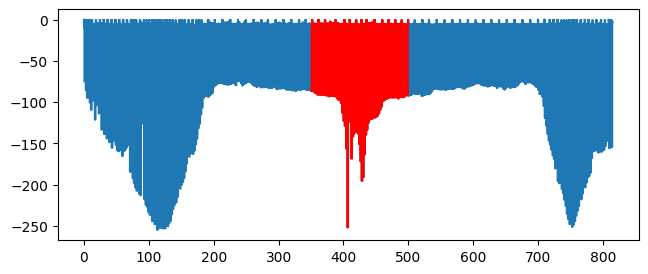

In [517]:
glider_data = './../GliderData/batray_delayed_trajectory.nc' # batray-2023-03-17-delayed_trajectory_file.nc
gl_raw = xr.open_dataset(glider_data,group='glider_record',decode_times=False)
gl = xr.open_dataset(glider_data,decode_times=False)

# Select index of data 
#dive = 550
indx = (gl.profile_index >350) & (gl.profile_index <500)

fig, ax = plt.subplots(1,1, figsize=(7.5, 3))
ax.plot(gl.profile_index, -gl.depth)
ax.plot(gl.profile_index[indx], -gl.depth[indx],'r')
#ax[1].plot(gl_raw['sci_rbrctd_timestamp'][indx],-gl.depth[indx],'.')
#ax[1].plot(gl_raw['sci_rbrctd_salinity_00'][indx],gl.salinity[indx],'.')
#ax[1].plot(np.linspace(31,34,10),np.linspace(31,34,10))

#import gsw
#df['salinity'] = gsw.conversions.SP_from_C(df['conductivity'] * 10, df['temperature'], df['pressure'])
#df['salinity_SA'] = gsw.conversions.SA_from_SP(df['salinity'], df['pressure'], df['lon'], df['lat'])
#df['temperature_CT'] = gsw.conversions.CT_from_t(df['salinity_SA'], df['temperature'], df['pressure'])
#df['density'] = gsw.density.rho(df['salinity_SA'], df['temperature_CT'], df['pressure'])

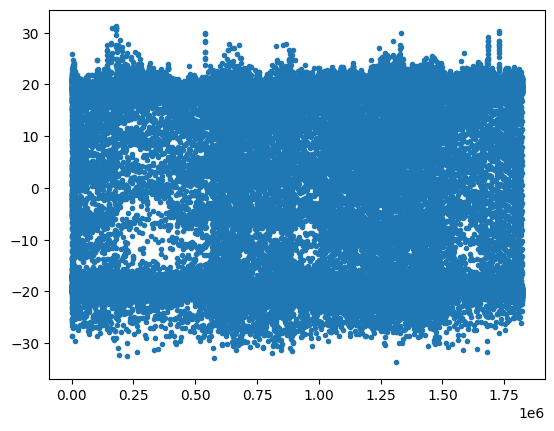

In [463]:
plt.plot(gl_raw['m_pitch'],'.')
#plt.ylim(-30,-10)

In [518]:
## Create data subset
# Extract the common time coordinate    
time = gl_raw['sci_rbrctd_timestamp'][indx]
#time = gl_raw['time'][indx]
# Create data subset ensuring all variables share the same time coordinate
ds_subset = xr.Dataset({
    'time': time,
    'pressure': (['time'], gl_raw['sci_water_pressure'][indx].values),
    'lon': (['time'], gl['lon_qc'][indx].values),
    'lat': (['time'], gl['lat_qc'][indx].values),
    'pitch': (['time'],gl_raw['m_pitch'][indx].values),
    'buoyancy':(['time'], gl_raw['m_de_oil_vol'][indx].values),
    'roll': (['time'],gl_raw['m_roll'][indx].values),
    'dive_nr':(['time'],gl['profile_index'][indx].values),
    'density':(['time'],gl['density'][indx].values)
})
df = ds_subset.to_dataframe().reset_index()
df = df.interpolate(method='linear') # Fill NaN gaps with linear interpolation
df = df.fillna(method='bfill').fillna(method='ffill') # Ensure there are no remaining NaNs
df = df.drop_duplicates(subset='time')  # Remove duplicate time values



(10200.0, 11000.0)

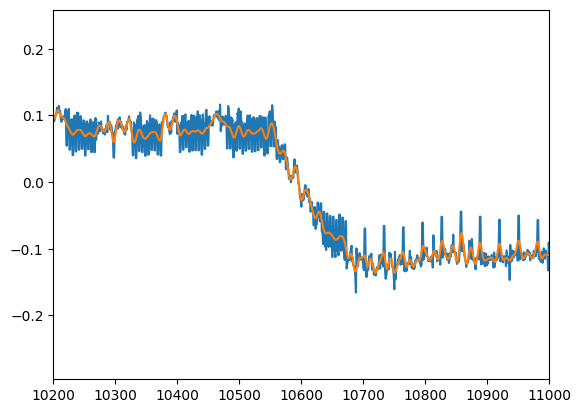

In [544]:
#window_size = 10  # You can adjust this window size to get the desired smoothing effect
#df['pressure_smoothed'] = df['pressure'].rolling(window=window_size).mean()

#from scipy.signal import savgol_filter
#window_length = 11  # Window length must be a positive odd integer
#polyorder = 3 # Polynomial order must be less than window_length
#df['pressure_smoothed'] = savgol_filter(df['pressure'], window_length, polyorder)

from scipy.signal import butter, filtfilt

# Apply a Butterworth filter to the pressure data
def butter_lowpass_filter(data, cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

# Define filter parameters
cutoff_frequency = 1 / 10  # 3-second cutoff frequency in Hz (1/3 Hz)
sampling_frequency = 1 / np.median(np.diff(df['time']))  # Sampling frequency of the data in Hz
order = 3  # Order of the filter

# Apply the filter
df['pressure_smoothed'] = butter_lowpass_filter(df['pressure'], cutoff_frequency, sampling_frequency, order)


plt.plot(df.index,np.concatenate(([0], np.diff(df.pressure))))
plt.plot(df.index,np.concatenate(([0], np.diff(df.pressure_smoothed))))
plt.xlim(10200,11000)

1026.7707155311564 0
Series([], Name: pressure, dtype: float64)


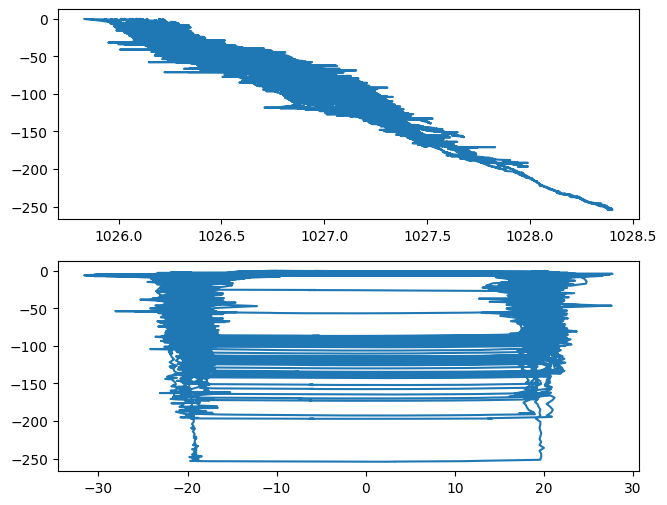

In [522]:
data = {
    'time': df.index.to_numpy()-np.min(df.index.to_numpy()),
    'pressure': df['pressure_smoothed'].to_numpy()/10,
    'pitch': np.deg2rad(df['pitch'].to_numpy()),
    'pitch_deg': df['pitch'].to_numpy(),
    'buoyancy_change': df['buoyancy'].to_numpy(),
    'density': df['density'].to_numpy(),
    'dive_nr': df['dive_nr'].to_numpy(),
    'roll': df['roll'].to_numpy(),
}

fig, ax = plt.subplots(2,1, figsize=(7.5, 6))
ax[0].plot(data['density'],-data['pressure']*10)
ax[1].plot(data['pitch_deg'],-data['pressure']*10)
print(np.mean(data['density'][data['pressure']*10>20]),np.min(data['time']))

print(df['pressure'][np.isnan(df['pressure'])])

In [523]:
import gliderflight

GM = gliderflight.SteadyStateCalibrate(rho0=1025)
GM.define(mg=74,Vg=74/1025,Cd0=0.098) # You want to either supply ah=3.8,Cd1=10.492 and or Cd0 but not both.
#data['dhdt']=GM.compute_dhdt(data['time'],data['pressure'])
GM.set_input_data(pitch=data['pitch'],buoyancy_change=data['buoyancy_change'],time=data['time'],
                  pressure=data['pressure'],density=data['density'])
GM.OR(data['pressure']*10<50)
GM.OR(data['pressure']*10>80)
calibration_result = GM.calibrate('Cd0','Vg',constraints="dhdt")# Optimize for Total Drag and volume. 
print(GM.get_settings())
print(GM.RHO0)
print(calibration_result)
#plt.plot(data['dhdt'])

{'Cd0': 0.21204916071352783, 'Cd1': 10.492635453419751, 'S': 0.1, 'eOsborne': 0.8, 'AR': 7, 'Omega': 0.7504915783575616, 'mg': 74, 'epsilon': 5e-10, 'Vg': 0.07208910571152279, 'Cd1_hull': 9.7, 'aw': 3.7342698372847303, 'ah': 3.8}
1025
{'Cd0': 0.21203946089704254, 'Vg': 0.07208910135508514}


In [153]:
# Run Steady State - DONT USE 2024-06-25 L. Merkelbach Discussion
#gm = gliderflight.SteadyStateGliderModel(rho0=1025)
#gm.define(Vg=74/1025, ah=3.8, mg=74, Cd0=0.098,Cd1=12)
#gm.solve_for_angle_of_attack
#ss_result=gm.solve(data)

In [270]:
# Run Dynamic Model DONT USE 2024-06-25 L. Merkelbach Discussion
#dm = gliderflight.DynamicGliderModel(rho0=1025, k1=0.2, k2=0.98, dt=2)
#dm.define(Vg=74/1025, ah=3.8, mg=74, Cd0=0.098,Cd1=12)
#pressure, buoyancy_change = dm.convert_pressure_Vbp_to_SI(data['pressure'],
#                                                          data['buoyancy_change'])
#data['FB'], data['Fg'] = dm.compute_FB_and_Fg(pressure,data['density'], buoyancy_change)
#dm.get_settings()
#alpha, U = dm.solve(data)

#dm.compute_lift_and_drag(FB)

Text(0, 0.5, 'Pitch[$^o$]')

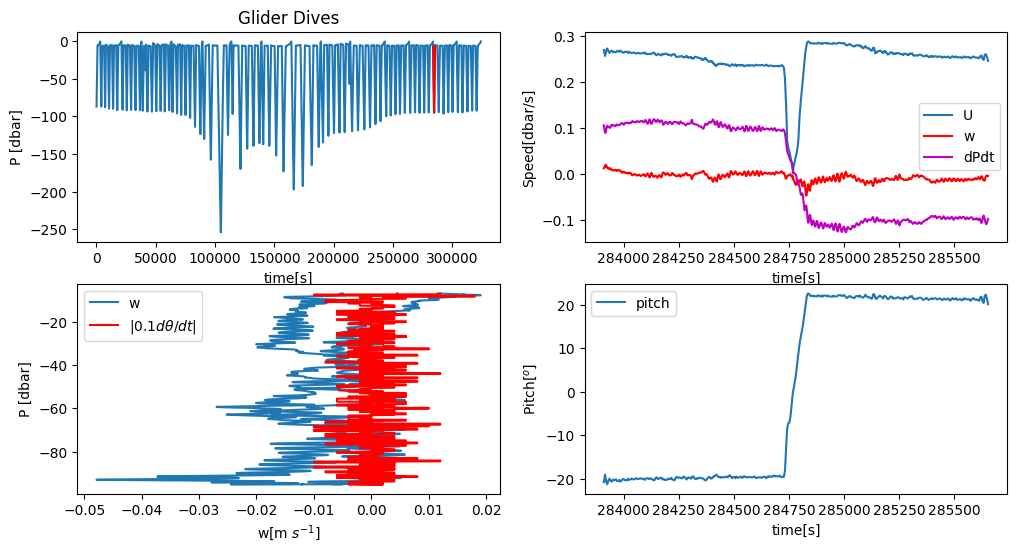

In [541]:
# gm.t # time
# gm.U # incident velocity
# gm.alpha # angle of attack
# gm.ug    # horizontal speed
# gm.wg    # vertical speed
# gm.w     # vertical water velocity

dPdt = np.concatenate(([0], np.diff(data['pressure']*10)))
roll_rate = np.concatenate(([0], np.diff(data['roll'])))

fig, ax = plt.subplots(2,2, figsize=(12, 6))

dive = 480
idx = (data['pressure']*10>7) & (data['pressure']*10<230) & ((data['dive_nr'] == dive) | (data['dive_nr'] == dive+1))


# Plot dive record
ax[0,0].plot(data['time'],-data['pressure']*10)
ax[0,0].plot(data['time'][idx],-data['pressure'][idx]*10,'r')
ax[0,0].set_title('Glider Dives')
ax[0,0].set_xlabel('time[s]')
ax[0,0].set_ylabel('P [dbar]')


# Plot Vertical velocity and selected dive
ax[0,1].plot(data['time'][idx],GM.U[idx],label='U')
ax[0,1].plot(data['time'][idx],GM.w[idx],'r',label='w')
ax[0,1].plot(data['time'][idx],dPdt[idx],'m',label='dPdt')
ax[0,1].set_xlabel('time[s]')
ax[0,1].set_ylabel('Speed[dbar/s]')
ax[0,1].legend()


# Plot Roll Rate and Vertical Velocity as a function of pressure

ax[1,0].plot(GM.w[idx],-data['pressure'][idx]*10,label='w')#
ax[1,0].plot(roll_rate[idx]/10,-data['pressure'][idx]*10,'r',label=r'$|0.1 d\theta/dt|$')
ax[1,0].legend()
ax[1,0].set_xlabel('w[m $s^{-1}$]')
ax[1,0].set_ylabel('P [dbar]')


ax[1,1].plot(data['time'][idx],data['pitch_deg'][idx], label='pitch')
ax[1,1].legend()
ax[1,1].set_xlabel('time[s]')
ax[1,1].set_ylabel('Pitch[$^o$]')

Text(0, 0.5, '|w|[m/s]')

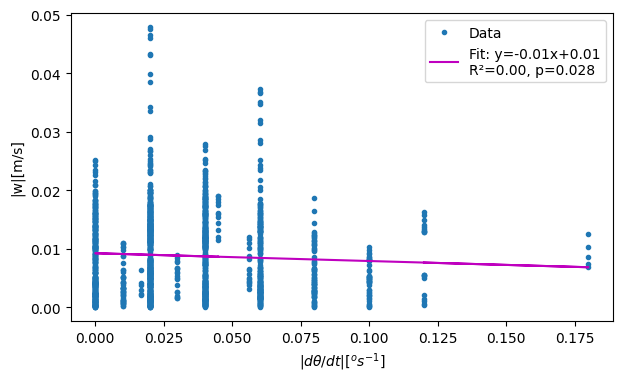

In [542]:
# Roll Rate v. Vertical Velocity
fig, ax = plt.subplots(1,1, figsize=(7, 4))

from scipy.stats import linregress
x_data = np.abs(roll_rate[idx])
y_data = np.abs(GM.w[idx])
ax.plot(x_data, y_data, '.', label='Data')

slope, intercept, r_value, p_value, std_err = linregress(x_data, y_data) # Perform linear regression
fit_line = slope * np.array(x_data) + intercept 

# Plot the linear fit
ax.plot(x_data, fit_line, label=f'Fit: y={slope:.2f}x+{intercept:.2f}\nR²={r_value**2:.2f}, p={p_value:.2g}', color='m')
ax.legend()
ax.set_xlabel(r'$|d\theta/dt|[^o s^{-1}]$')
ax.set_ylabel('|w|[m/s]')

In [449]:
#plt.plot(dPdt,'.')